In [1]:
import numpy as np
import os, sys
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
import re
import concurrent.futures
from sklearn.metrics import silhouette_score
from scipy.stats import pearsonr
from collections import OrderedDict
import copy
import pickle
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import cloudpickle
from contextlib import contextmanager

from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import CTGANSynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import get_column_plot

import dask.dataframe as dpd
import dask_geopandas as dgpd
from dask.diagnostics import ProgressBar
from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

/home/grads/l/lipai.huang/GAN_simulated_events/se_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@contextmanager
def custom_torch_load(map_location):
    original_torch_load = torch.load

    def custom_load(*args, **kwargs):
        kwargs['map_location'] = map_location
        return original_torch_load(*args, **kwargs)

    torch.load = custom_load
    try:
        yield
    finally:
        torch.load = original_torch_load

In [3]:
import gc
gc.collect()

16

In [4]:
map_location = 'cuda:0'

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
client = Client(n_workers=100) #128 totally

In [7]:
config = yaml.safe_load(open('../config.yaml'))

In [8]:
print(torch.__version__, torch.cuda.is_available())

2.0.1+cu118 True


In [55]:
# torch.cuda.set_device(0)

# Coord

In [9]:
coord_gdf = gpd.read_file('../src/coord/coord_gdf.shp')
coord_gdf = coord_gdf.drop(columns=['cell_rmse1', 'cell_r21', 'cell_rmse2', 'cell_r22', 'depth'])

In [10]:
static_gdf = coord_gdf[['x', 'y', 'channel', 'ter', 'geometry']]
static_gdf

,x,y,channel,ter,geometry
0,2.933766e+06,1.396557e+07,0,301.388702,"POLYGON ((2934366.000 13964974.635, 2933003.17..."
1,2.934966e+06,1.396557e+07,0,301.594696,"POLYGON ((2934366.000 13967369.160, 2934380.33..."
2,2.933766e+06,1.396437e+07,0,294.629181,"POLYGON ((2934366.000 13964974.635, 2934366.00..."
3,2.934966e+06,1.396437e+07,0,298.529877,"POLYGON ((2935566.000 13963774.635, 2934366.00..."
4,2.936166e+06,1.396437e+07,0,294.815002,"POLYGON ((2936766.000 13963774.635, 2935566.00..."
...,...,...,...,...,...
26296,3.039069e+06,1.385008e+07,1,54.643570,"POLYGON ((3039427.707 13849492.726, 3038745.86..."
26297,3.039053e+06,1.385088e+07,1,59.625050,"POLYGON ((3039399.212 13851153.541, 3039405.50..."
26298,3.038396e+06,1.385006e+07,0,60.055576,"POLYGON ((3038723.769 13850469.724, 3038724.68..."
26299,3.038392e+06,1.385087e+07,0,59.625050,"POLYGON ((3038721.900 13851266.014, 3038723.76..."


In [11]:
coord_union_gdf = gpd.GeoDataFrame(geometry=[coord_gdf.unary_union], crs=coord_gdf.crs)

# Real events

In [12]:
np.random.seed(0)
sample_event_num = 50
event_indices = np.random.choice(range(593), sample_event_num, replace=False)
event_indices

array([240, 132, 571,  92, 170, 449, 573, 471, 187, 229, 181, 239, 587,
       390, 438, 402, 590, 142, 246, 378, 394,  85, 196, 173, 367, 278,
       178,   1, 334, 517,  14, 222, 584, 103, 426, 351,   8, 585, 213,
       320,  21, 379, 118, 250, 282, 516, 557,  48,  52, 336])

In [13]:
scaler = MinMaxScaler()
xy_scaled = scaler.fit_transform(coord_gdf[['x', 'y']])

def load_and_scale(file_path, scale=False):
    df = pd.read_parquet(file_path)[['x', 'y', 'channel', 'ter', 'cumu_rain', 'peak_int', 'duration', 'depth']]
    if scale:
        df[['x', 'y']] = xy_scaled
    return df
file_paths = [f'../src/tables/data{i}.parquet' for i in event_indices]
selected_events = [load_and_scale(file, scale=True) for file in file_paths]
with ProgressBar():
    result = dpd.concat(selected_events, axis=0)
selected_events_df = result.compute()
selected_events_df = selected_events_df.drop(columns=['channel', 'ter', 'depth']).reset_index(drop=True)

# Depth model

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim=1, num_heads=8, num_layers=4, transform_dim=128):
        super(TransformerModel, self).__init__()
        self.input_transform = nn.Linear(input_dim, transform_dim)

        # Transformer specific layers
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=transform_dim, 
            nhead=num_heads,
            dim_feedforward=2048,  
            dropout=0.25  
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # Output layer
        self.fc_out = nn.Linear(transform_dim, output_dim)

    def forward(self, src):
        src = self.input_transform(src)
        transformed = self.transformer_encoder(src)
        output = self.fc_out(transformed)
        return output

In [15]:
device = torch.device('cuda:0')

In [16]:
model = TransformerModel(5).to(device)

In [17]:
tf_checkpoint = torch.load('../checkpoints/depth/best_model_0_1e-05.pth', map_location='cuda:0')

In [18]:
new_state_dict = OrderedDict()
for k, v in tf_checkpoint.items():
    # Remove 'module.' prefix
    name = k[7:]  # skip 'module.' (7 characters)
    new_state_dict[name] = v

# Load the adjusted state dict into your model
model.load_state_dict(new_state_dict)

<All keys matched successfully>

# cCTGAN

In [17]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(selected_events_df)

In [ ]:
lr_sets = config['gan_lr_sets']
filtered_res_df = pd.DataFrame(columns=['G_LR', 'D_LR', 'Epochs', 'rows', 'Effective Column Shapes'])
for lrs in tqdm(lr_sets, total=len(lr_sets)):
    for epoch in tqdm(range(50, config['gan_epochs']+1, 50), desc=f'{lrs[0]}_{lrs[1]}', total=len(range(50, config['gan_epochs']+1, 50))):
        filtered_df_path = f'../outputs/augmented_data/{lrs[0]}_{lrs[1]}_{epoch}.parquet'
        if not os.path.exists(filtered_df_path):
            with custom_torch_load(map_location):
                ctgan_synthesizer = CTGANSynthesizer.load(filepath=f'../checkpoints/cCTGAN/{lrs[0]}_{lrs[1]}_{epoch}.pkl')
            print('Generating events...')
            ctgan_synthetic_df = ctgan_synthesizer.sample(num_rows=5000000)
            ctgan_synthetic_df[['x', 'y']] = scaler.inverse_transform(ctgan_synthetic_df[['x', 'y']])
            ctgan_synthetic_gdf = gpd.GeoDataFrame(
                ctgan_synthetic_df, 
                geometry=gpd.points_from_xy(ctgan_synthetic_df.x, ctgan_synthetic_df.y),
                crs=coord_gdf.crs
            )
            print('Filtering...')
            ctgan_synthetic_inbound_df = ctgan_synthetic_gdf.sjoin(coord_union_gdf, predicate='within').drop(columns=['geometry', 'index_right'])
            ctgan_synthetic_inbound_df.to_parquet(filtered_df_path)
        else:
            ctgan_synthetic_inbound_df = pd.read_parquet(filtered_df_path)
        quality_report = evaluate_quality(
            real_data=selected_events_df,
            synthetic_data=ctgan_synthetic_inbound_df,
            metadata=metadata, verbose=False)
        q_res = dict(zip(filtered_res_df.columns, [lrs[0], lrs[1], epoch, len(ctgan_synthetic_inbound_df), quality_report.get_details(property_name='Column Shapes').iloc[2:]['Score'].mean()]))
        filtered_res_df.loc[len(filtered_res_df)] = q_res
        print(q_res)

2e-5_1e-5:   0%|                                                                                                                        | 0/6 [00:00<?, ?it/s]

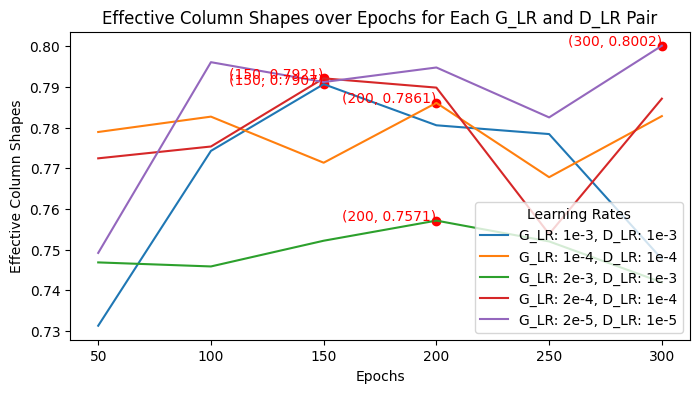

In [28]:
# Group by G_LR and D_LR
grouped = filtered_res_df.groupby(['G_LR', 'D_LR'])

# Plot
plt.figure(figsize=(8, 4))
for (g_lr, d_lr), group in grouped:
    sns.lineplot(x='Epochs', y='Effective Column Shapes', data=group, label=f'G_LR: {g_lr}, D_LR: {d_lr}')

    # Find the max Effective Column Shapes point
    max_row = group.loc[group['Effective Column Shapes'].idxmax()]
    max_epoch = max_row['Epochs']
    max_shape = max_row['Effective Column Shapes']

    # Highlight and annotate the max point
    plt.scatter(max_epoch, max_shape, color='red')
    plt.text(max_epoch, max_shape, f'({int(max_epoch)}, {round(max_shape, 4)})', color='red', ha='right')

plt.xlabel('Epochs')
plt.ylabel('Effective Column Shapes')
plt.title('Effective Column Shapes over Epochs for Each G_LR and D_LR Pair')
plt.legend(title='Learning Rates', loc='lower right')
plt.show()

In [29]:
filtered_res_df

,G_LR,D_LR,Epochs,rows,Effective Column Shapes
0,2e-5,1e-5,50,4394850,0.749179
1,2e-5,1e-5,100,3888402,0.796108
2,2e-5,1e-5,150,4310757,0.791218
3,2e-5,1e-5,200,4217959,0.794801
4,2e-5,1e-5,250,4292694,0.782521
5,2e-5,1e-5,300,4369436,0.800156
6,1e-4,1e-4,50,4232411,0.778932
7,1e-4,1e-4,100,4385691,0.782710
8,1e-4,1e-4,150,4694140,0.771372
9,1e-4,1e-4,200,4700406,0.786094


In [19]:
ctgan_synthetic_df = pd.read_parquet(f'../outputs/augmented_data/2e-5_1e-5_300.parquet')
ctgan_synthetic_gdf = gpd.GeoDataFrame(
    ctgan_synthetic_df, 
    geometry=gpd.points_from_xy(ctgan_synthetic_df.x, ctgan_synthetic_df.y),
    crs=coord_gdf.crs
)

In [20]:
ctgan_synthetic_gdf

,x,y,cumu_rain,peak_int,duration,geometry
0,3.070848e+06,1.395185e+07,2.028108,0.404348,14,POINT (3070848.208 13951846.106)
1,3.007831e+06,1.392808e+07,1.301862,0.333165,3,POINT (3007830.753 13928081.441)
2,3.147958e+06,1.388166e+07,0.035497,0.000000,1,POINT (3147958.359 13881657.334)
3,3.076232e+06,1.384572e+07,2.217226,4.174754,4,POINT (3076232.149 13845720.194)
4,3.051338e+06,1.391060e+07,1.039234,1.260012,7,POINT (3051338.371 13910597.814)
...,...,...,...,...,...,...
4999994,3.165582e+06,1.379762e+07,9.373292,4.883581,5,POINT (3165582.152 13797622.959)
4999995,2.945508e+06,1.385003e+07,2.090193,2.870242,9,POINT (2945508.332 13850034.793)
4999996,3.183778e+06,1.382983e+07,8.759537,1.880709,5,POINT (3183777.598 13829829.431)
4999997,3.070211e+06,1.389988e+07,14.319854,2.906695,16,POINT (3070210.897 13899880.091)


In [37]:
get_column_plot(
    real_data=selected_events_df,
    synthetic_data=ctgan_synthetic_gdf.drop(columns=['geometry']),
    metadata=metadata,
    column_name='cumu_rain'
).show()

In [38]:
get_column_plot(
    real_data=selected_events_df,
    synthetic_data=ctgan_synthetic_gdf.drop(columns=['geometry']),
    metadata=metadata,
    column_name='peak_int'
).show()

In [39]:
get_column_plot(
    real_data=selected_events_df,
    synthetic_data=ctgan_synthetic_gdf.drop(columns=['geometry']),
    metadata=metadata,
    column_name='duration'
).show()

In [21]:
coord_dgdf = dgpd.from_geopandas(coord_gdf, npartitions=10)
ctgan_synthetic_dgdf = dgpd.from_geopandas(ctgan_synthetic_gdf, npartitions=500)

In [22]:
ctgan_synthetic_feat_static_dgdf = ctgan_synthetic_dgdf.sjoin(coord_dgdf[['channel', 'ter', 'geometry']], predicate='within')

In [23]:
ctgan_synthetic_feat_static_gdf = ctgan_synthetic_feat_static_dgdf.compute()

In [24]:
ctgan_synthetic_feat_static_gdf = ctgan_synthetic_feat_static_gdf.drop(columns=['index_right'])

In [25]:
ctgan_synthetic_feat_static_gdf

,x,y,cumu_rain,peak_int,duration,geometry,channel,ter
0,3.070848e+06,1.395185e+07,2.028108,0.404348,14,POINT (3070848.208 13951846.106),0,128.006729
15,3.138509e+06,1.393107e+07,0.814155,1.388835,3,POINT (3138508.842 13931065.374),0,79.065697
1258,3.138369e+06,1.393059e+07,9.210388,17.113158,3,POINT (3138368.923 13930586.769),0,79.065697
33,3.030618e+06,1.394084e+07,8.017052,3.207797,5,POINT (3030618.245 13940836.564),0,156.468750
43,2.938629e+06,1.394260e+07,1.069939,0.235279,2,POINT (2938628.833 13942596.755),0,233.210526
...,...,...,...,...,...,...,...,...
4999874,3.150696e+06,1.385620e+07,0.850719,1.894187,1,POINT (3150695.977 13856199.210),1,18.980492
4999879,3.012808e+06,1.385354e+07,10.247778,5.452115,5,POINT (3012808.140 13853543.106),1,97.975548
4999899,2.934805e+06,1.391727e+07,0.070056,2.654061,3,POINT (2934804.904 13917273.125),1,227.769867
4999921,3.035107e+06,1.380791e+07,2.751928,2.407199,5,POINT (3035106.608 13807911.968),1,70.938553


In [26]:
pred_tensor = torch.tensor(ctgan_synthetic_feat_static_gdf[['channel', 'ter', 'cumu_rain', 'peak_int', 'duration']].values, dtype=torch.float32).to(device)

In [27]:
batch_size = 1000
n_samples = pred_tensor.size(0)
predictions = []

model.eval()

with torch.no_grad(): 
    for i in trange(0, n_samples, batch_size):
        batch = pred_tensor[i:i+batch_size]
        batch_predictions = model(batch)
        predictions.append(batch_predictions)

predictions = torch.cat(predictions, dim=0)

predictions = predictions.cpu().numpy()

100%|██████████| 4369/4369 [00:22<00:00, 195.78it/s]


In [28]:
ctgan_synthetic_feat_static_gdf['syn_depth'] = predictions

In [29]:
ctgan_synthetic_feat_static_gdf

,x,y,cumu_rain,peak_int,duration,geometry,channel,ter,syn_depth
0,3.070848e+06,1.395185e+07,2.028108,0.404348,14,POINT (3070848.208 13951846.106),0,128.006729,1.649017
15,3.138509e+06,1.393107e+07,0.814155,1.388835,3,POINT (3138508.842 13931065.374),0,79.065697,1.743952
1258,3.138369e+06,1.393059e+07,9.210388,17.113158,3,POINT (3138368.923 13930586.769),0,79.065697,2.602597
33,3.030618e+06,1.394084e+07,8.017052,3.207797,5,POINT (3030618.245 13940836.564),0,156.468750,1.850432
43,2.938629e+06,1.394260e+07,1.069939,0.235279,2,POINT (2938628.833 13942596.755),0,233.210526,1.648227
...,...,...,...,...,...,...,...,...,...
4999874,3.150696e+06,1.385620e+07,0.850719,1.894187,1,POINT (3150695.977 13856199.210),1,18.980492,1.796558
4999879,3.012808e+06,1.385354e+07,10.247778,5.452115,5,POINT (3012808.140 13853543.106),1,97.975548,1.565761
4999899,2.934805e+06,1.391727e+07,0.070056,2.654061,3,POINT (2934804.904 13917273.125),1,227.769867,0.955412
4999921,3.035107e+06,1.380791e+07,2.751928,2.407199,5,POINT (3035106.608 13807911.968),1,70.938553,1.301932


In [30]:
ctgan_synthetic_depth_events_df = ctgan_synthetic_feat_static_gdf.drop(columns=['geometry']).reset_index(drop=True)

In [31]:
ctgan_synthetic_depth_events_df.to_parquet('../outputs/aggregated_syn_events.parquet')

In [45]:
syn_durs= sorted(pd.unique(ctgan_synthetic_feat_static_gdf['duration']))
syn_durs

[1, 2, 3, 4, 5, 6, 7, 9, 14, 16]

In [54]:
for dur in tqdm(syn_durs, total=len(syn_durs)):
    plt.clf() 
    simple_cluster_gdf = ctgan_synthetic_feat_static_gdf[ctgan_synthetic_feat_static_gdf['duration'] == dur]
    fig, ax = plt.subplots(figsize=(8, 6))
    simple_cluster_gdf.plot(ax=ax, column='syn_depth', cmap='coolwarm', s=1, vmin=0, vmax=30, legend=False, alpha=0.1)
    norm = Normalize(vmin=0, vmax=30)
    sm = ScalarMappable(norm=norm, cmap='coolwarm')
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('syn_depth')
    ax.set_title(f'Simply clustered by duration={dur} with {len(simple_cluster_gdf)} rows')
    fig.savefig(f'../outputs/vis/simple_by_duration/{dur}.png')
    plt.close(fig)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:45<00:00, 22.57s/it]


<Figure size 640x480 with 0 Axes>